In [1]:
%load_ext autoreload
%autoreload 2

import models.dataset as ds
import glob
import matplotlib.pyplot as plt
import torch
from pytorch_msssim import ms_ssim
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from models.util import *
import imageio

dataset_path = './Data/'
device = "cuda" if torch.cuda.is_available() else "cpu"


In [120]:
dataset_dict = dict()
for ds_type in ['train','val','test']:
    dataset_dict[ds_type] = dict()
    dataset_dict[ds_type]['path'] = dataset_path + ds_type + '/'
    filepath_all_gt = glob.glob(dataset_dict[ds_type]['path']+'/groundtruth/*')
    filepath_all_blur = glob.glob(dataset_dict[ds_type]['path']+'/input/*')
    dataset_dict[ds_type]['dataset'] = ds.NanoDataset(filepath_all_gt,filepath_all_blur,transform=ds.ToTensor())

dataset_train = dataset_dict['train']['dataset']
dataset_test = dataset_dict['test']['dataset']

batch_size = 8

dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=1)
dataloader_train = DataLoader(dataset_test, batch_size, shuffle=True, num_workers=1)

print('Training Data Size:',len(dataset_train))

Training Data Size: 7839


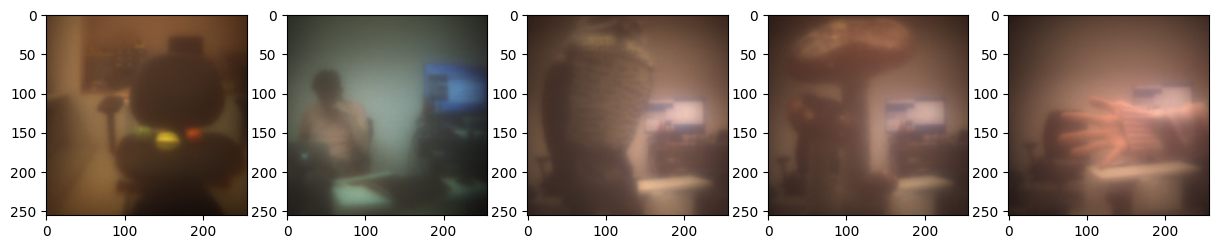

In [37]:
cap_path = glob.glob('Data/real/*')
dataloader_cap = DataLoader(ds.TestNanoDataset(cap_path),5,shuffle=True, num_workers=1)
show_tensor_image(next(iter(dataloader_cap)))

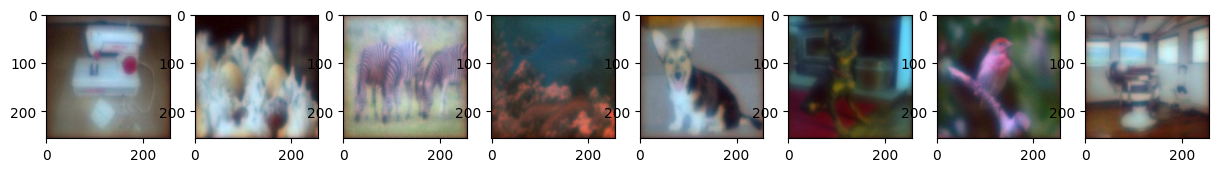

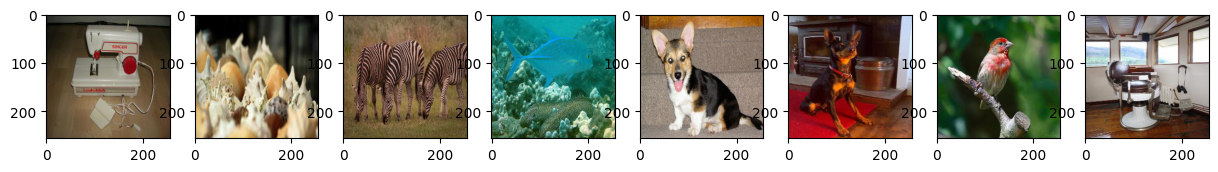

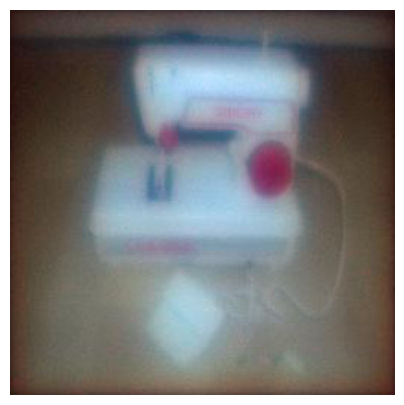

In [4]:
image_tensor_dict = next(iter(dataloader_train))
show_tensor_image(image_tensor_dict['blur'])
show_tensor_image(image_tensor_dict['gt'])
show_tensor_first_image(image_tensor_dict['blur'])

In [12]:
load_path = None#'u_net_model.pt'
epochs = 20
network = 'unet'
loss_type = 'l1'

In [13]:
from models.unet import Unet
num_in_channels = 3

unet_model = Unet(n_channel_in=num_in_channels, n_channel_out=3, residual=False, down='conv', up='tconv', activation='selu').to(device)
model = unet_model

if load_path is not None:
    model.load_state_dict(torch.load('saved_models/'+load_path,map_location=torch.device(device)))
    print('loading saved model')

lr = 0.001
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

unet_model

Unet(
  (down1): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), groups=32)
  (down2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2), groups=64)
  (down3): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2), groups=128)
  (down4): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2), groups=256)
  (up1): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2), groups=256)
  (up2): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), groups=128)
  (up3): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), groups=64)
  (up4): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2), groups=32)
  (conv1): ConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actfun1): LeakyReLU(negative_slope=0.01)
    (actfun2): LeakyReLU(negative_slope=0.01)
  )
  (conv2): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

epoch:  0  batch:  0  loss:  0.49703773856163025
epoch:  0  batch:  100  loss:  0.09015338122844696
epoch:  10  batch:  0  loss:  0.087149813771247863
epoch:  10  batch:  100  loss:  0.07061392813920975


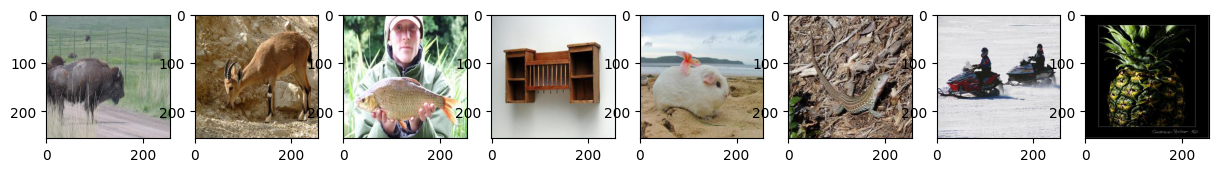

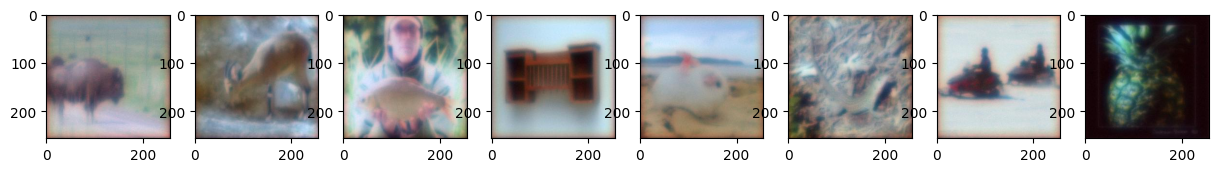

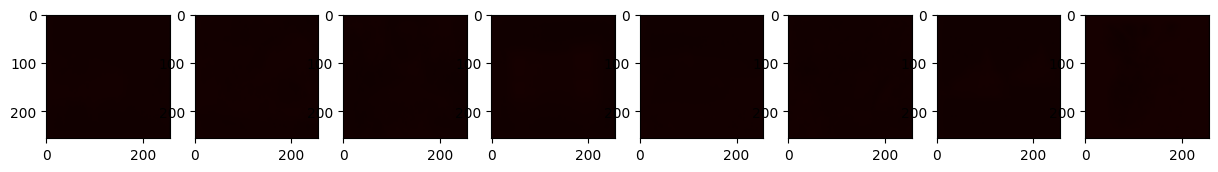

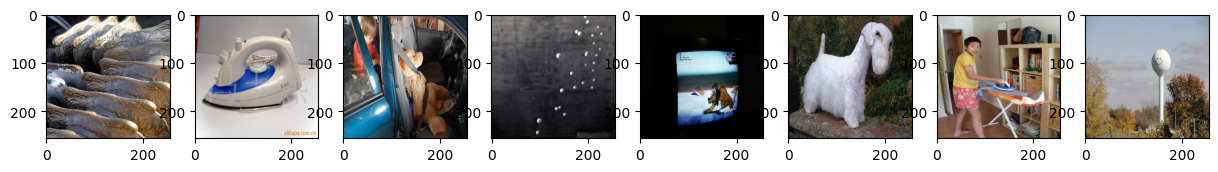

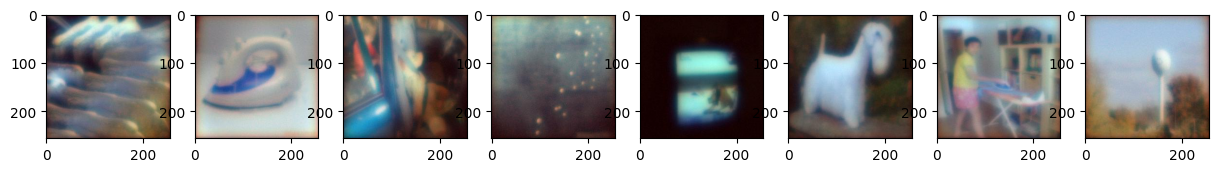

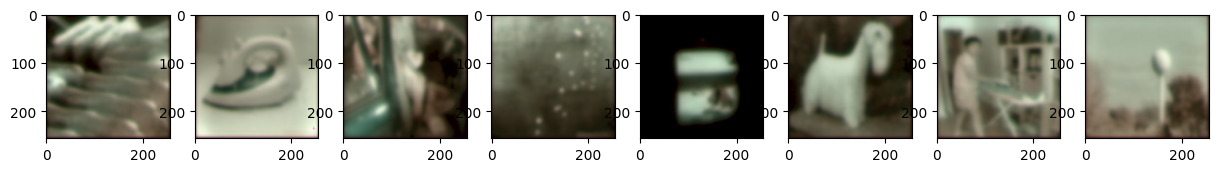

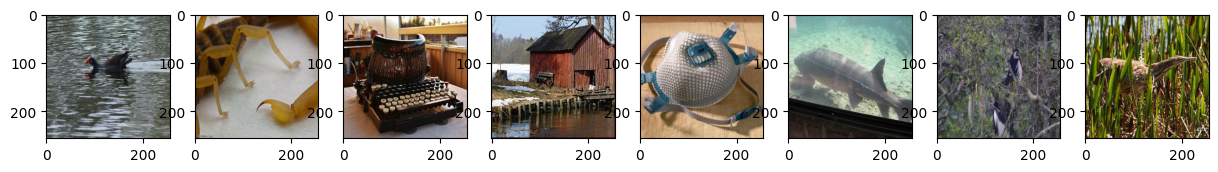

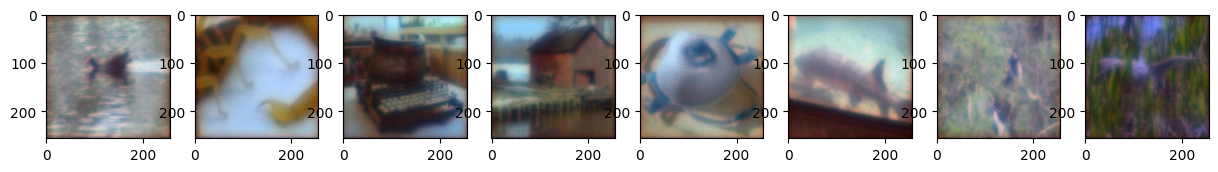

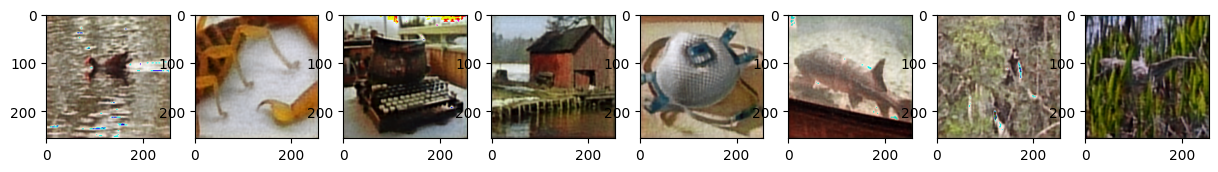

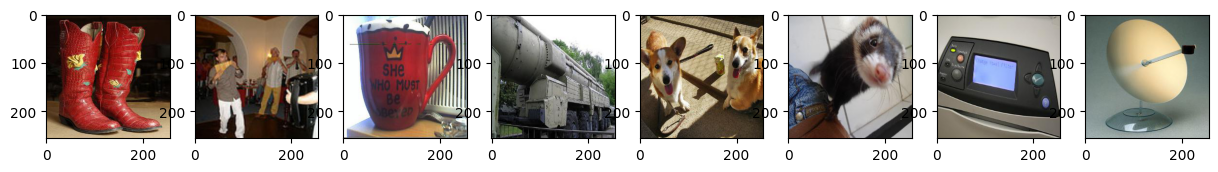

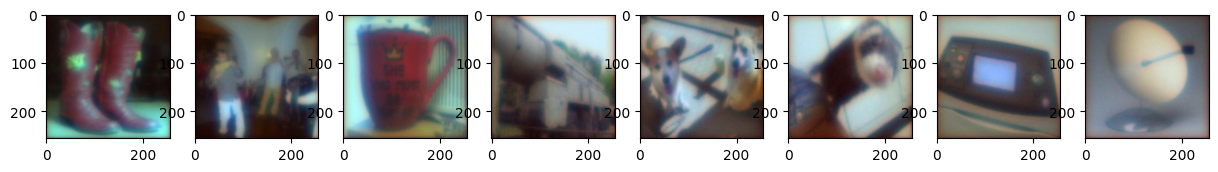

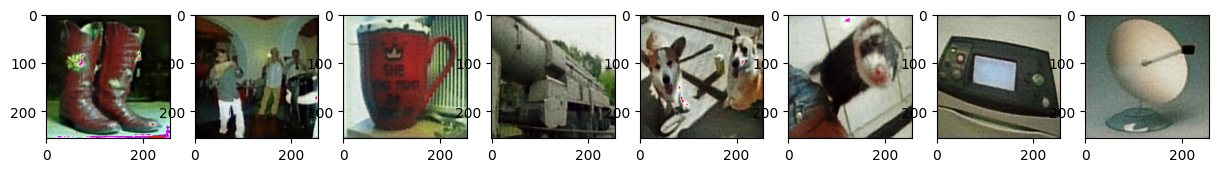

In [14]:
for itr in range(0,epochs):
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()

        input = sample_batched['blur']
        x = reshape_image_to_train(input).to(device)
        out = model(x)

        gt = sample_batched['gt']
        gt_in_loss = reshape_image_to_train(gt).to(device)

        if loss_type=='l1':
            loss = loss_fn(out, gt_in_loss)
        else:
            loss = loss_fn(out, gt_in_loss)+(1- ms_ssim( out[0], gt_in_loss[0], data_range=1, size_average=False))
        loss.backward()
        optimizer.step()
        print('epoch: ', itr, ' batch: ', i_batch, ' loss: ', loss.item(), end='\r')


        if i_batch%100 == 0 and itr%10 ==0:
            print('epoch: ', itr, ' batch: ', i_batch, ' loss: ', loss.item())
            display_results(input,gt,out)
    #break

In [15]:
filepath_save = 'saved_models/'
torch.save(model.state_dict(), filepath_save + 'u_net_model.pt')

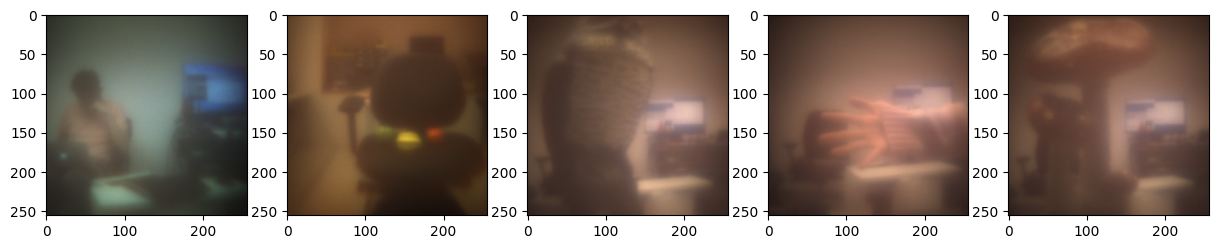

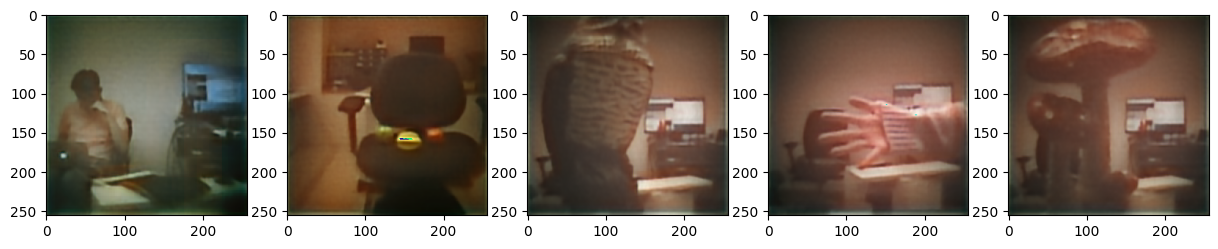

In [16]:
input = next(iter(dataloader_cap))
x = reshape_image_to_train(input).to(device)
out_cap = model(x)
show_tensor_image(input)
show_output_tensor(out_cap)

In [127]:
from models.unet import Unet
import models.wiener_model as wm
psf_path = 'Data/PSF/'
num_in_channels = 3

psfs = load_np_psf(psf_path,256,256)
print(psfs.shape)
Ks = np.ones((num_in_channels,1,1))*0.005
unet_model = Unet(n_channel_in=num_in_channels, n_channel_out=3, residual=False, down='conv', up='tconv', activation='selu').to(device)
wiener_model=wm.WienerDeconvolution3D(psfs,Ks).to(device)

model_wm=wm.MyEnsemble(wiener_model,unet_model)

if load_path is not None:
    model.load_state_dict(torch.load('saved_models/'+load_path,map_location=torch.device(device)))
    print('loading saved model')

lr = 0.001
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_wm

(3, 256, 256)


MyEnsemble(
  (wiener_model): WienerDeconvolution3D()
  (unet_model): Unet(
    (down1): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), groups=32)
    (down2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2), groups=64)
    (down3): Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2), groups=128)
    (down4): Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2), groups=256)
    (up1): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2), groups=256)
    (up2): ConvTranspose2d(128, 128, kernel_size=(2, 2), stride=(2, 2), groups=128)
    (up3): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2), groups=64)
    (up4): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2), groups=32)
    (conv1): ConvBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (actfun1): LeakyReLU(negative_slope=0.01)
      (actfun2): LeakyReLU(negative_slope=0.01)
    )
    (

In [ ]:
epochs = 200
for itr in range(0,epochs):
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()

        input = sample_batched['blur']
        x = reshape_image_to_train(input).to(device)
        out = model_wm(x.cuda())

        gt = sample_batched['gt']
        gt_in_loss = reshape_image_to_train(gt).to(device)

        if loss_type=='l1':
            loss = loss_fn(out, gt_in_loss)
        else:
            loss = loss_fn(out, gt_in_loss)+(1- ms_ssim( out[0], gt_in_loss[0], data_range=1, size_average=False))
        loss.backward()
        optimizer.step()
        print('epoch: ', itr, ' batch: ', i_batch, ' loss: ', loss.item(), end='\r')


        if i_batch%100 == 0 and (itr+1)%10 == 0:
            print('epoch: ', itr, ' batch: ', i_batch, ' loss: ', loss.item())
            display_results(input,gt,out)
        #break
    #break

filepath_save = 'saved_models/'
torch.save(model_wm.state_dict(), filepath_save + 'wm_net_model.pt')

torch.Size([2, 256, 256, 3])
(3, 256, 256)
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


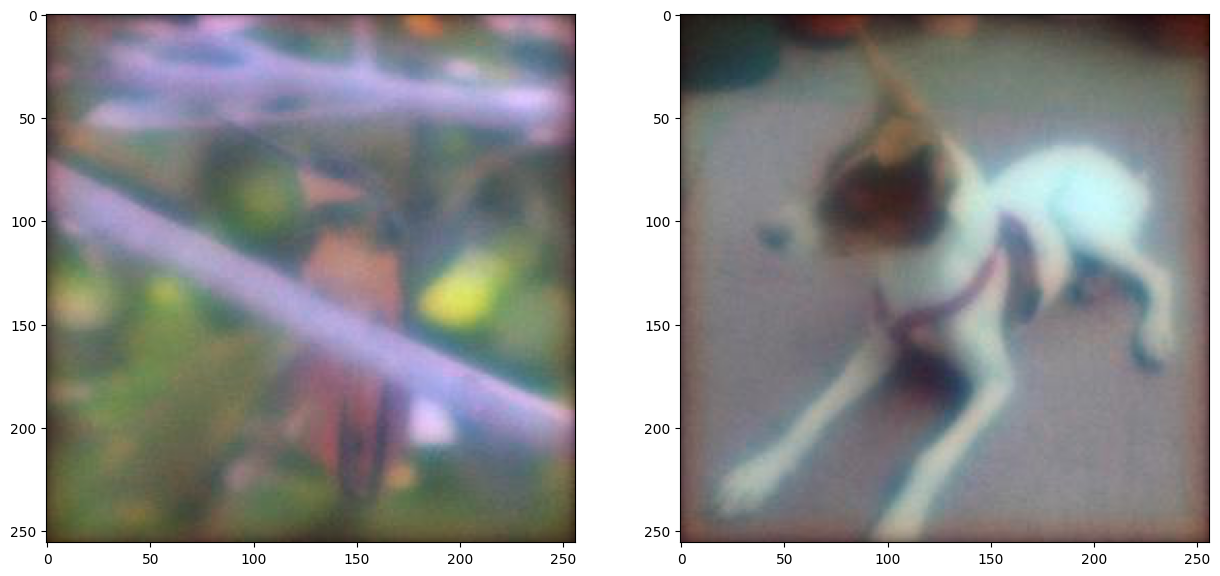

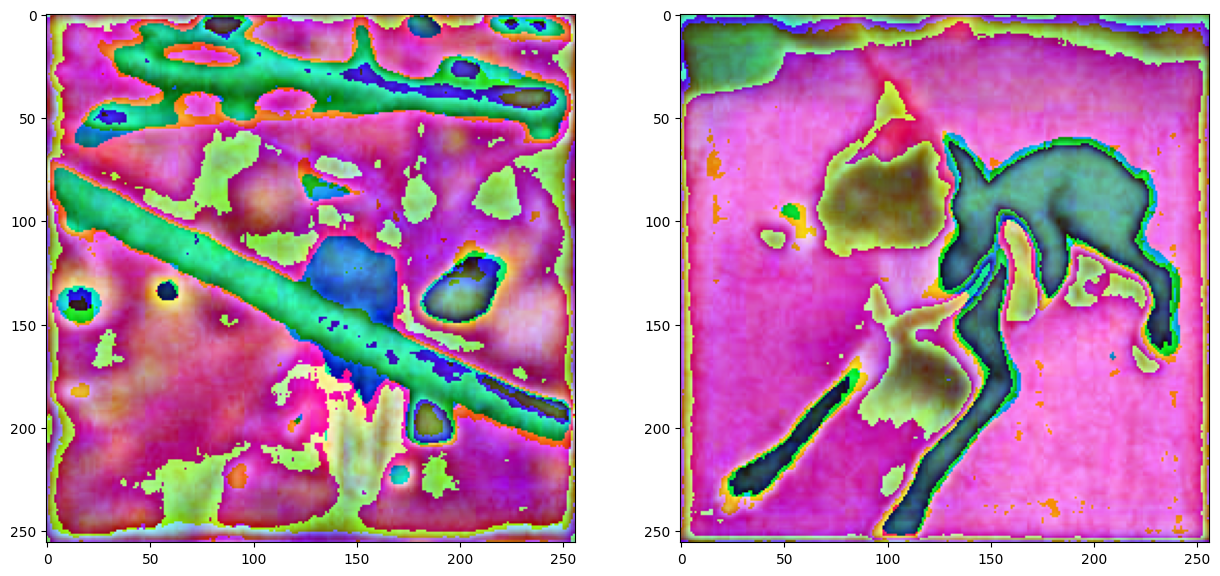

In [119]:

def weiner_filter(img,kernel,K):
    kernel /= torch.sum(kernel)
    #dummy = torch.clone(img)
    dummy = torch.fft.fft2(img)
    #kernel = torch.unsqueeze(kernel,0).repeat(8,1,1,1)
    print(kernel.shape)
    kernel = torch.fft.fft2(kernel)
    print(kernel.shape)
    kernel = torch.conj(kernel)/(torch.abs(kernel)**2 + K)
    dummy = dummy * kernel
    dummy = torch.fft.ifftshift(torch.real(torch.fft.ifft2(dummy)),dim=(-2, -1))
    return dummy
    



for i_batch, sample_batched in enumerate(dataloader_train):
    input = sample_batched['blur']
    show_tensor_image(input)
    x = reshape_image_to_train(input)
    print(input.shape)
    psfs = load_np_psf(psf_path,256,256)
    kernels = torch.from_numpy(psfs)
    print(psfs.shape)
    out = weiner_filter(x,kernels,0.005)
    show_output_tensor(out)
    

    break
